# EMP Metabolomics feature table distribution visualization

Author: Louis Felix Nothias, UC San Diego 

Date: 2021/01/11

### Objectifs:
Define the threshold for filtering feature intensities that are noise being introduced by the gap filling step
 
### Steps:

- Take and prepare the feature table and merge it with the metadata
- Visualize the distribution of intensities based on main metadata ("lcms_sample_type", "lcms_sample_type_sub")

### Code notes
The code should handle standard ion identity networking table but the metadata handling has specific handling for the EMP500 metadata table. 

## Prepare the script -> run the following cells

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Define the feature tables
filename_before_gapfill = 'feature_table/EMPsubset_before_gapfill_quant.csv'
filename_after_gapfill = 'feature_table/EMPsubset_after_gapfill_quant.csv'

#Define metadata filename
metadata_filename = 'metadata/emp500_metadata_basic.txt'

In [187]:
# This function takes a feature table and metadata table. Concatenate them. Filter based on metadata and visualize.
def function(filename,max_intensity,subset1=None,value1=None,subset2=None, value2=None, plot_color='Blue'):
    ft = pd.read_table(filename, index_col=None, header=0, sep=',', low_memory=False, skiprows=0)
    #Drop IIN columns
    ft = ft.drop(columns=['row m/z','row retention time','correlation group ID', 'annotation network number','best ion','auto MS2 verify','identified by n=','partners','neutral M mass'])
    # Get the correct column type
    ft = ft.infer_objects()
    ft = ft.set_index('row ID', drop=True)
    # Tranpose the table
    ft_T = ft.T
    ft_T['duplicate_check'] = ft_T.index

    # Removing metabolomics sample duplicate filenames (these are not critical samples, mostly technical samples)
    ft2 = ft_T
    ft2 = ft2[~ft2.duplicate_check.str.contains("Unnamed: 815")]
    ft2 = ft2[~ft2.duplicate_check.str.contains("Peak area.")]
    ft2["duplicate_check"] = ft2["duplicate_check"].str.rstrip(" croppped Peak area")
    #ft2 = ft2.drop(columns=['duplicate_check']) 
    ft2 = ft2.set_index('duplicate_check', drop=True)
    
    # Replace 0 by NaN
    ft2 = ft2.replace(0,np.nan)
    ft2["lcms_sample_name_fbmn"] = ft2.index
    ft2.head(3)
    
    md = pd.read_table(metadata_filename, index_col=None, header=0, sep='\t', usecols=['lcms_sample_name_fbmn','lcms_extraction_protocol',
       'lcms_sample_type', 'lcms_sample_type_sub','lcms_batch','emp500_principal_investigator', 'emp500_study_id',
       'emp500_pi_study_id', 'emp500_title', 'empo_0', 'empo_1', 'empo_2',
       'empo_3', 'env_biome', 'env_feature', 'env_material'])

    md_filtered = md[~md.lcms_batch.str.contains("not applicable")]
    md_filtered = md_filtered.infer_objects()
    md_filtered["lcms_batch"] = md_filtered["lcms_batch"].astype(float).astype(int)


    df = pd.merge(md_filtered,ft2, on=['lcms_sample_name_fbmn'], how='right')
    df.head(2)
    
    # Filter the table based on subset/value
    try: 
        df = df[df[subset1] == value1]
    except:
        pass
    try: 
        df = df[df[subset2] == value2]
    except:
        pass
    
    try: 
        for x in df.columns:
            if x in md.columns:
                df = df.drop(columns=[x])
    except:
        pass

    
    # Make a long list for visualization
    big_liste = []
    for x in df.columns:
        try:
            liste = df[x].to_list()
            liste = [x for x in liste if x <= max_intensity]
            big_liste = big_liste + liste
        except:
            continue
        
    # Visualize
    fig, ax1 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax1 = sns.violinplot(x=big_liste,color=plot_color)
        
    plt.xlabel("Feature Intensity", size=11)

    try:
        #plt.title("EMP: Distribution plot for metabolomics feature intensity for all features (below "+str(max_intensity)+"\n Samples="+str(df.shape[0])+" Features="+str(df.shape[1]), size=10)
        #plt.title("EMP: Distribution plot for metabolomics feature intensity (below "+str(max_intensity)+")\n for subset "+str(subset1)+"/"+str(value1)+"\n Samples="+str(df.shape[0])+" Features="+str(df.shape[1]), size=12)
        plt.title("EMP: Distribution plot for metabolomics feature intensity (below "+str(max_intensity)+")\n for subset "+str(subset1)+"/"+str(value1)+" and "+str(subset2)+"/"+str(value2)+"\n Samples="+str(df.shape[0])+" Features="+str(df.shape[1]), size=12)
    except:
        pass
    
    fig, ax2 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax2 = sns.distplot(big_liste, kde = True, bins = 100, color=plot_color)
    plt.xlabel("Density", size=11)

## Lets visualize all the data -> run the cells (THIS IS SLOW TO RUN, skip if needed)

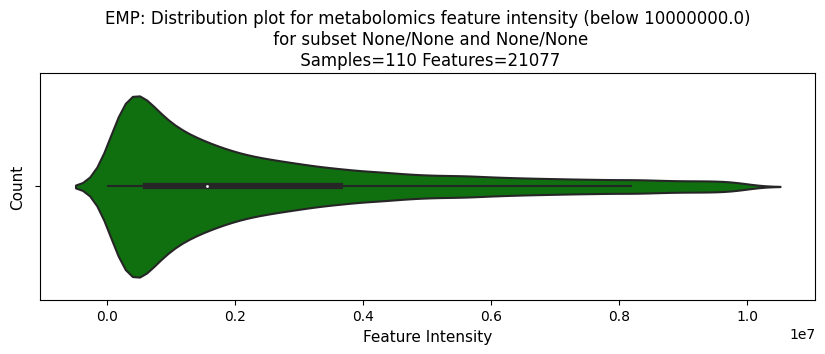

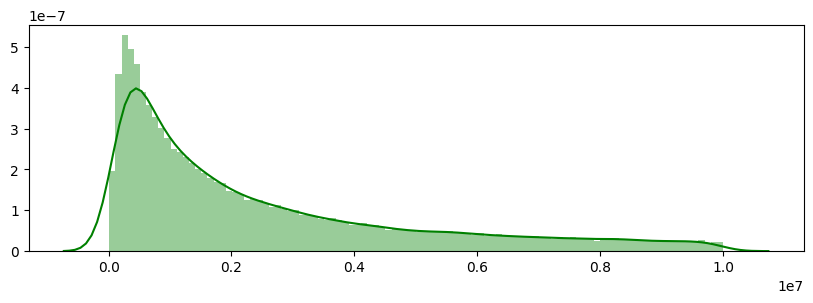

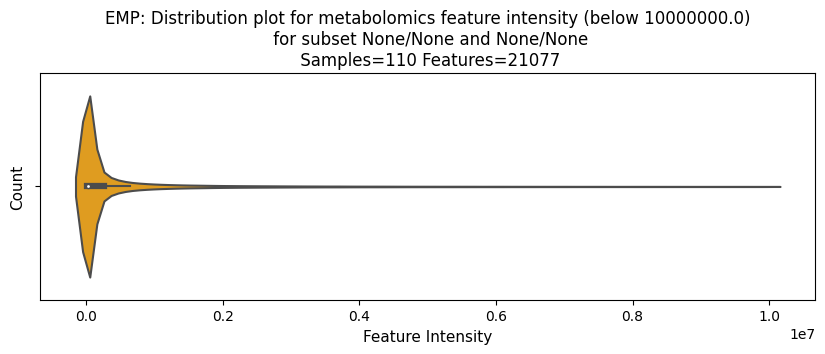

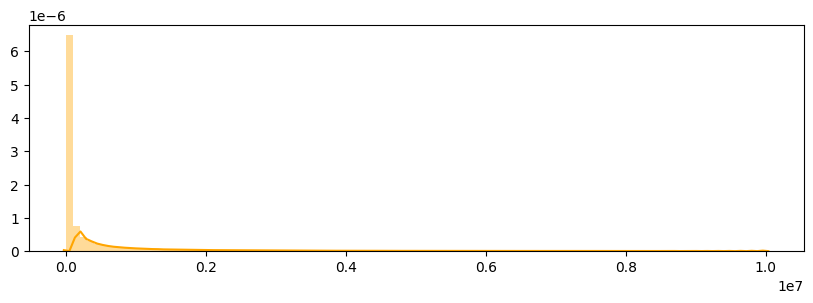

In [178]:
function(filename_before_gapfill, max_intensity=1E7, plot_color="green")
function(filename_after_gapfill, max_intensity=1E7, plot_color="orange")

## Metadata examination -> run the following cell to see metadata columns

In [169]:
# Just run the cell
md = pd.read_table(metadata_filename, index_col=None, header=0, sep='\t', usecols=['lcms_sample_name_fbmn','lcms_extraction_protocol',
       'lcms_sample_type', 'lcms_sample_type_sub','lcms_batch','emp500_principal_investigator', 'emp500_study_id',
       'emp500_pi_study_id', 'emp500_title', 'empo_0', 'empo_1', 'empo_2',
       'empo_3', 'env_biome', 'env_feature', 'env_material'])
md_filtered = md[~md.lcms_batch.str.contains("not applicable")]
md_filtered = md_filtered.infer_objects()
md_filtered["lcms_batch"] = md_filtered["lcms_batch"].astype(float).astype(int)
print('This are the metadata columns')
md_filtered.dtypes
#list(md_filtered["lcms_batch"])

This are the metadata columns


lcms_sample_name_fbmn            object
lcms_batch                        int64
lcms_extraction_protocol         object
lcms_sample_type                 object
lcms_sample_type_sub             object
emp500_principal_investigator    object
emp500_study_id                  object
emp500_pi_study_id               object
emp500_title                     object
empo_0                           object
empo_1                           object
empo_2                           object
empo_3                           object
env_biome                        object
env_feature                      object
env_material                     object
dtype: object

## Check the metadata values -> specify the subsets to be used for filtering

In [170]:
#Specify the subsets
subset1 = "lcms_sample_type"
subset2 = "lcms_batch"

# The values in that column
print(subset1)
print(set(md_filtered[subset1]))
print(subset2)
# The values in that column
print(set(md_filtered[subset2]))

lcms_sample_type
{'Qcmix', 'Sample', 'QC6mix', 'Material_control', 'Blank'}
lcms_batch
{1, 2, 3, 4, 5, 6, 7, 8, 9}


## Lets visualize the data for subset(s) -> run the cells

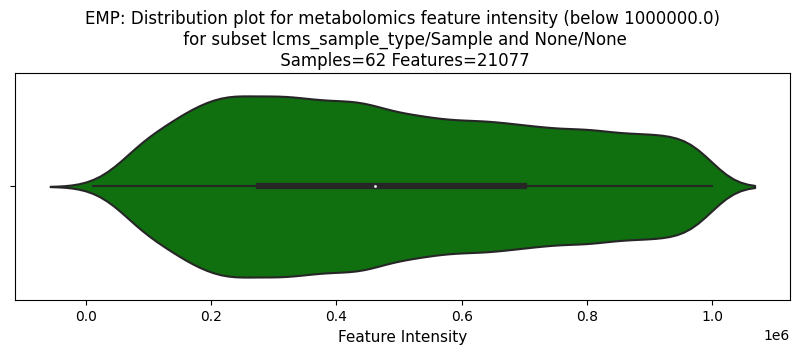

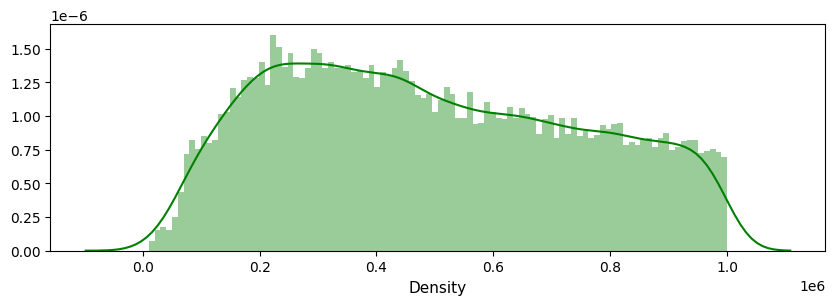

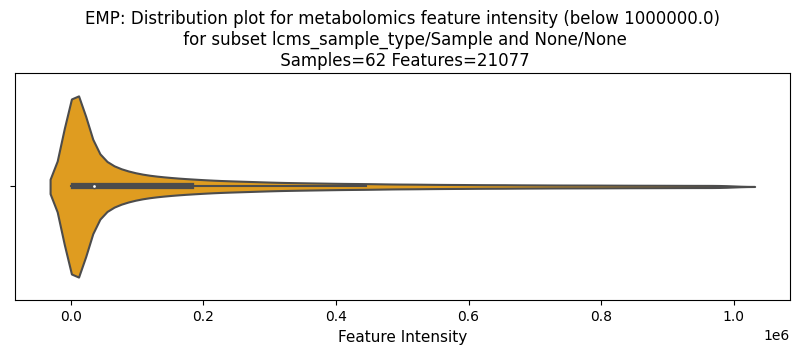

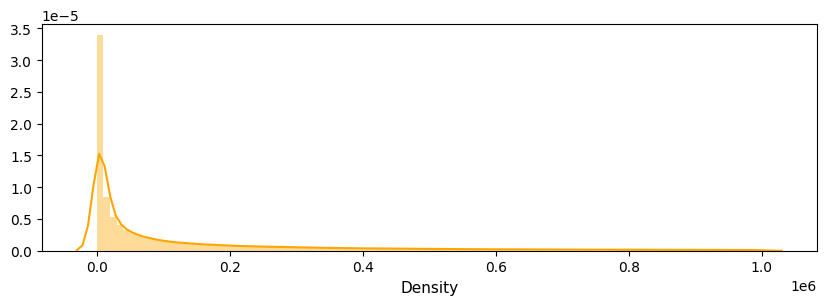

In [188]:
# View distribution for SAMPLES
function(filename_before_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Sample", plot_color="green")
function(filename_after_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Sample", plot_color="orange")

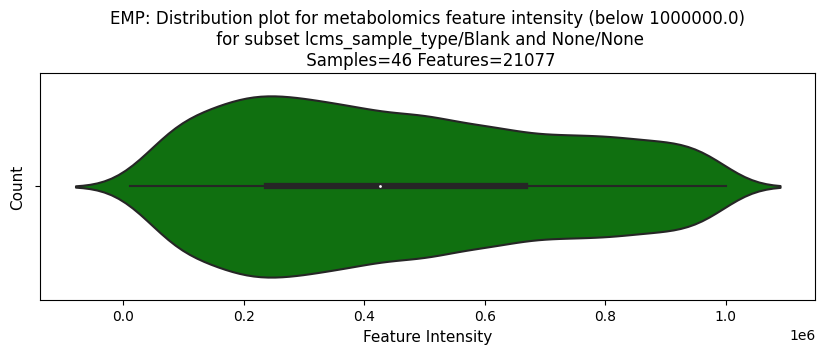

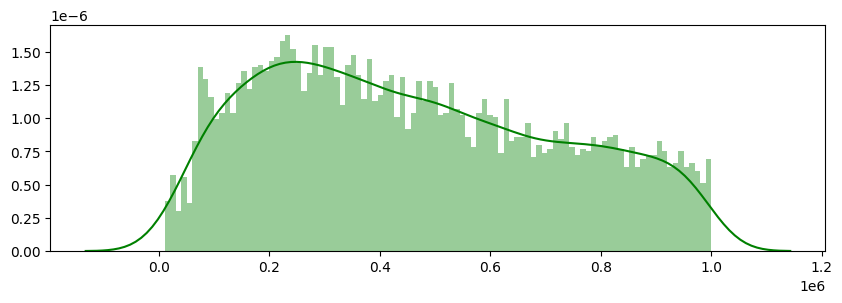

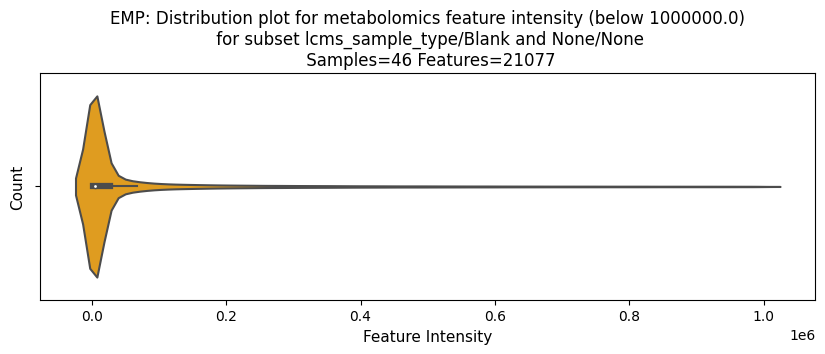

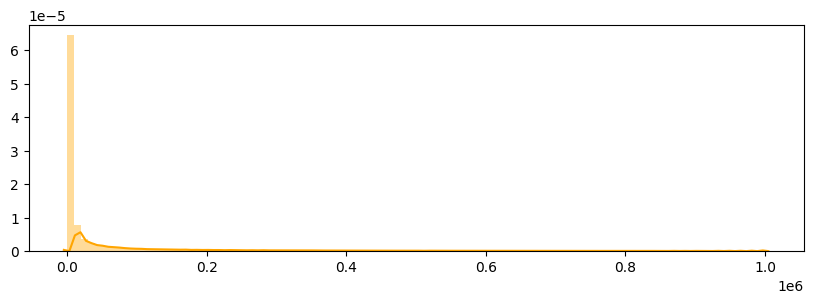

In [175]:
# View distribution for Blank
function(filename_before_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Blank", plot_color="green")
function(filename_after_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Blank", plot_color="orange")

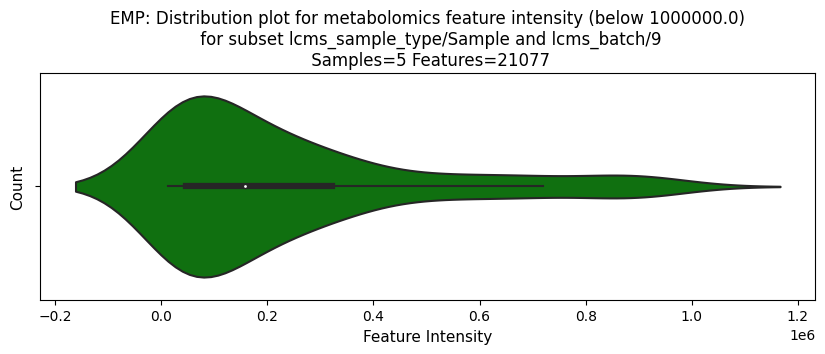

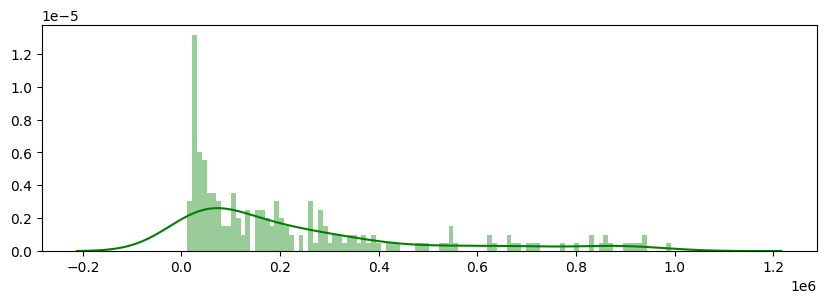

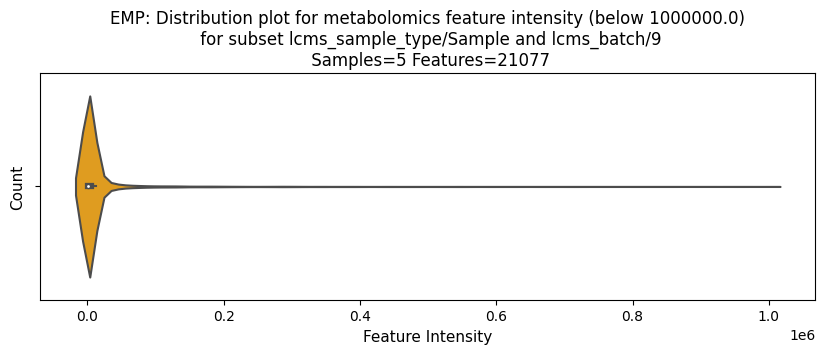

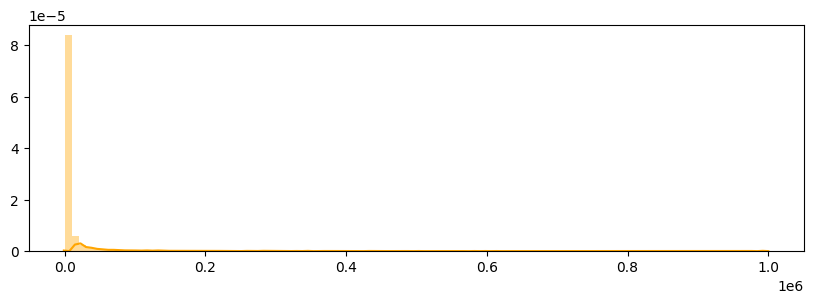

In [177]:
# View distribution for SAMPLES in batch 1
function(filename_before_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=9, plot_color="green")
function(filename_after_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=9, plot_color="orange")

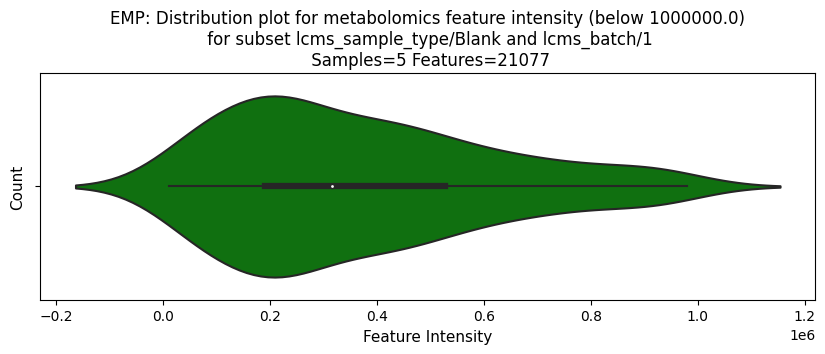

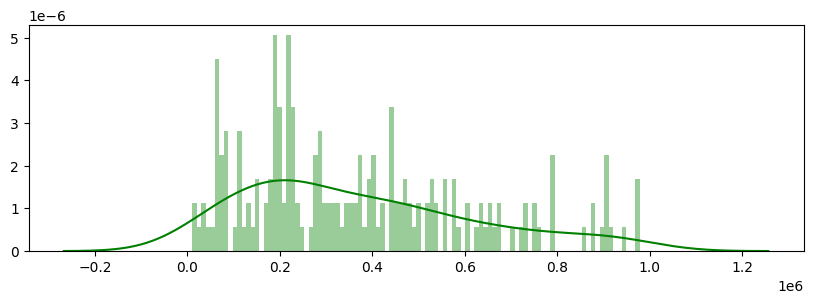

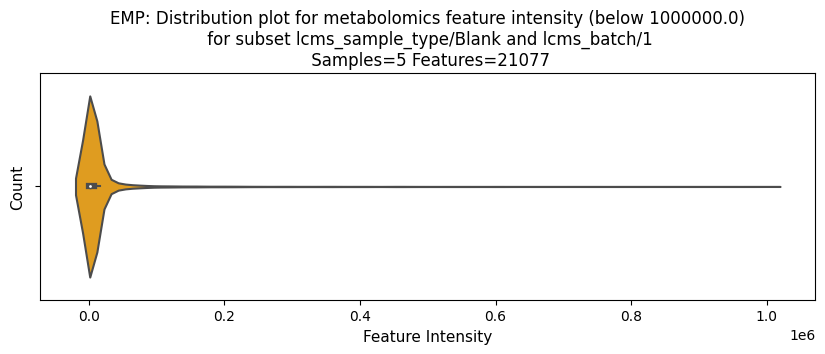

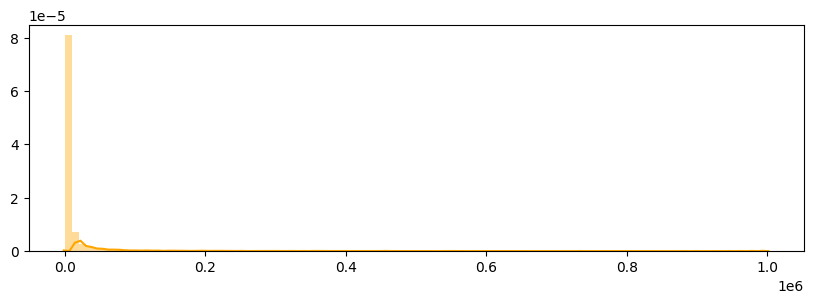

In [176]:
# View distribution for BLANKS in batch 1
function(filename_before_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Blank", subset2="lcms_batch", value2=1, plot_color="green")
function(filename_after_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Blank", subset2="lcms_batch", value2=1, plot_color="orange")

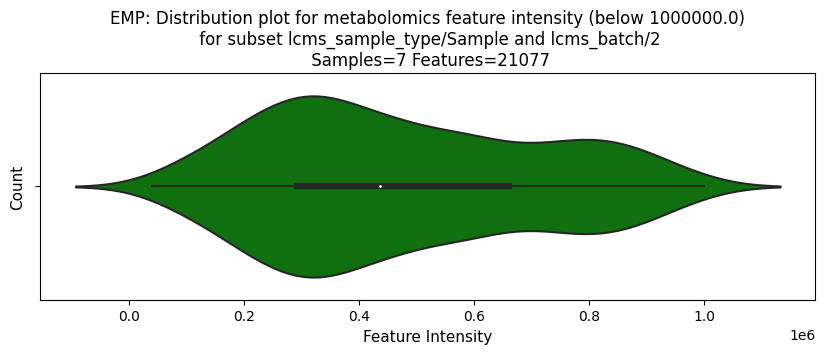

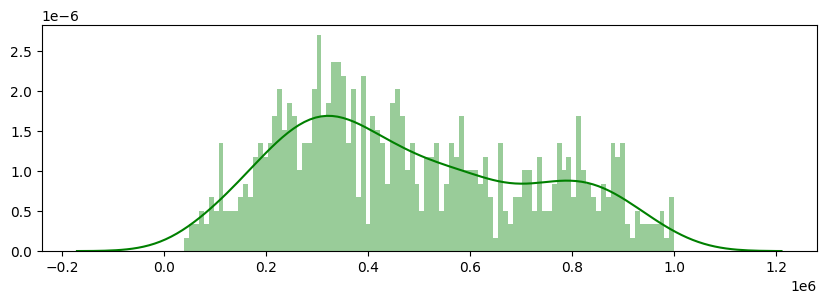

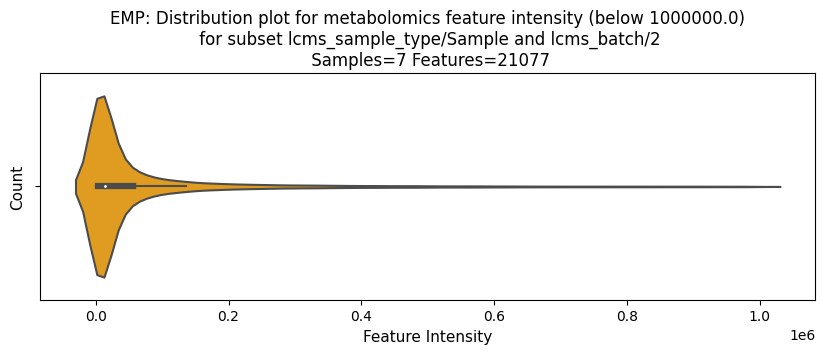

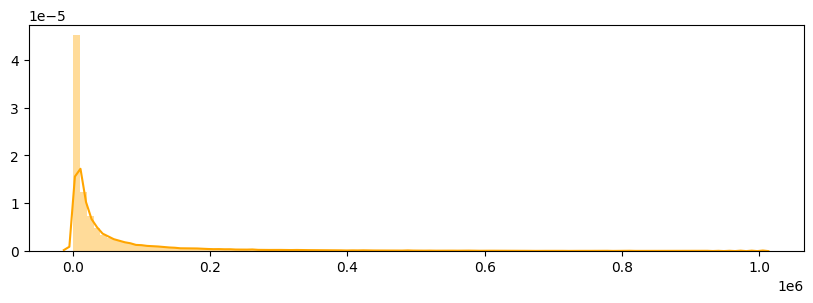

In [174]:
# View distribution for SAMPLES in batch 2
function(filename_before_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=2, plot_color="green")
function(filename_after_gapfill, max_intensity=1E6, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=2, plot_color="orange")